# (Theoretical) Observations of Cores and Filaments

We have derived sizes and shapes of cores and filaments.  What do they look like, in observations, in theory?

This lecture will cover:

* Core and filament structure
* Observational modeling

Our goal is to predict what we would detect with a telescope and how that would appear.

# Prediction

One of the main goals of theoretical physics in general is to develop predictive models for the universe.

We have pretty good models of how some things (like stars) work.

We can take that knowledge and predict what we will see using a telescope.  We can predict how many photons, what wavelength, and where they are.

This prediction is a key part of any telescope proposal: We want to make sure, if we point our telescope at something, we detect what we're looking for.  Preparing observations is a key application of theoretical astrophysics.

## We can *model* what we observe and predict what we'll see at other wavelengths
Nielbock 2012:
<img src="graphics/nielbock2012_b68.png">

We start with the adopted centrally-flattened density profile:

\begin{eqnarray}
    \rho(r) & = & \rho_c \frac{(c \cdot r_0)^\alpha}{(c \cdot r_0)^\alpha + r^\alpha}\\
            & = &  \rho_c \frac{1}{1 + (r/(c \cdot r_0))^\alpha}
\end{eqnarray}


In [1]:
# we're goign to do some plotting, so I'll show some imports & setup stuff
%matplotlib inline
import pylab as pl
pl.style.use('dark_background')
pl.rcParams['figure.dpi'] = 100
pl.rcParams['font.size'] = 14
from astropy.visualization import quantity_support, simple_norm

In [2]:
from astropy import units as u, constants

In [3]:
def rho(r, r0=2870*u.au, c=2.24, alpha=2.33, rho_c=3.5e-19*u.g/u.cm**3):
    return rho_c / (1+(r/(c*r0))**alpha)

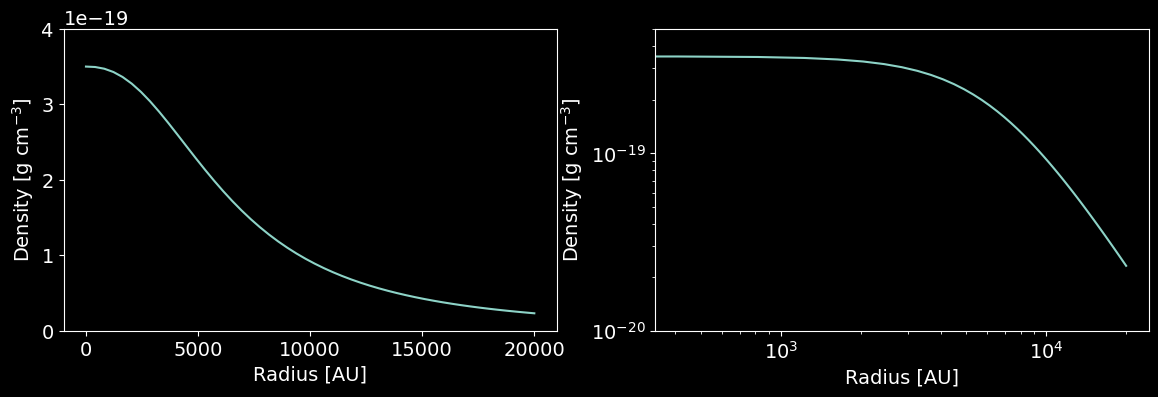

In [4]:
rr = np.linspace(0, 20000)*u.au
pl.figure(figsize=(14,4))
pl.subplot(1,2,1).plot(rr, rho(rr)); pl.xlabel("Radius [AU]"); pl.ylabel("Density [g cm$^{-3}$]"); pl.ylim(0, 4e-19);
pl.subplot(1,2,2).loglog(rr, rho(rr)); pl.xlabel("Radius [AU]"); pl.ylabel("Density [g cm$^{-3}$]"); pl.ylim(1e-20, 5e-19);


\begin{eqnarray}
    \rho(r) & = & \rho_c \frac{(c \cdot r_0)^\alpha}{(c \cdot r_0)^\alpha + r^\alpha}\\
            & = &  \rho_c \frac{1}{1 + (r/(c \cdot r_0))^\alpha}
\end{eqnarray}


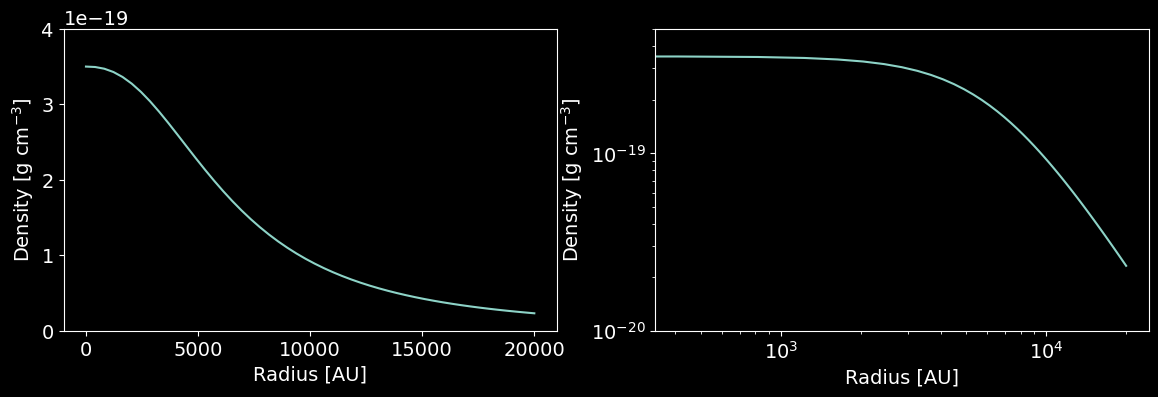

In [5]:
rr = np.linspace(0, 20000)*u.au
pl.figure(figsize=(14,4))
pl.subplot(1,2,1).plot(rr, rho(rr)); pl.xlabel("Radius [AU]"); pl.ylabel("Density [g cm$^{-3}$]"); pl.ylim(0, 4e-19);
pl.subplot(1,2,2).loglog(rr, rho(rr)); pl.xlabel("Radius [AU]"); pl.ylabel("Density [g cm$^{-3}$]"); pl.ylim(1e-20, 5e-19);

We'll start with $\alpha=2.33$ and $c=2.24$ as a good approximation for the Bonnor-Ebert sphere (see homework).

For local clouds, we'll adopt a temperature $T=15$ K and a pressure $P/k = 1 \times 10^5$ K cm$^{-3}$ to match B68

We'll obtain $\rho_c$ and $r_0$ from the Bonnor-Ebert solution:

In [6]:
T = 15*u.K
mu = 2.3*u.Da
P_over_K = 1e5*u.K * u.cm**-3

c_s = np.sqrt(constants.k_B * T / mu).to(u.km/u.s)
c_s

<Quantity 0.2328621 km / s>

\begin{equation}
M_{\rm BE} = 1.18 \frac{c_s^4}{\sqrt{G^3 P_s}}
\end{equation}

In [7]:
# 1.18 is the maximum dimensionless mass
M_BE = (1.18 * c_s**4 /
        (constants.G**(3./2.)) / (P_over_K * constants.k_B)**0.5).to(u.M_sun)
print(f"M_BE = {M_BE}")

M_BE = 2.7234605363985884 solMass


From homework:
$$\rho_S = 1.18^2 \frac{c_s^6}{M^2 G^3} $$
$$\rho_c = \rho_S e^{-\psi_S} = 13.77 \rho_S$$

In [8]:
# 1.18 is the maximum dimensionless mass
rho_S = (1.18**2*c_s**6 / M_BE**2 / constants.G**3).to(u.g/u.cm**3)
# 13.77 is the contrast rho_S/rho_c at maximum mass
rho_c = rho_S * 13.77
volume_density = (rho_c/(2.8*u.Da)).to(u.cm**-3)
print(f"Central & min density: {rho_c:0.2g}, {rho_S:0.2g}  (n_c = rho_c/mu_h2 = {volume_density:0.2g})")

Central & min density: 3.5e-19 g / cm3, 2.5e-20 g / cm3  (n_c = rho_c/mu_h2 = 7.5e+04 1 / cm3)


From homework:
$\xi \equiv r/r_0$
$$ r_0 = \sqrt{\frac{c_s^2}{\rho_c 4 \pi G}}$$

In [9]:
# r0 is the scaling constant, xi = r / r0
r0 = (c_s / (4 * np.pi * constants.G * rho_c)**0.5).to(u.au)
print(f"r0 = {r0.to(u.au):0.1f}")

r0 = 2870.5 AU


Assuming the core remains optically thin and isothermal, we need only to determine its column density to determine its observable properties.

Optically thin: we can see all the way through, so we just need to know how much light each particle produces.

Isothermal: We know how warm all the gas is, and it's all the same, so we can use a (modified) blackbody equation to predict the emission.

Optical depth is related to surface density.

Surface density $\Sigma = \int \rho dr$ - it is simply the sum of the density along the line of sight.

$$
\Sigma = \rho_c c r_0^\alpha \int_{-\infty}^\infty \frac{1}{(c r_0)^\alpha +r^\alpha} dr
$$

It's easiest to evaluate this numerically.

I'm going to walk through a 'complete' simulation of a BE sphere as observed at 1 mm wavelength

In [10]:
import numpy as np

In [11]:
# make a 3d grid:
sz = 100 # set the resolution: but not too big!
zz, yy, xx = grid = np.indices([sz, sz, sz])

In [12]:
# calculate radius from center

# set r_max = twice 6.4 r_0 (the 'core' is not defined outside this radius)
# 6.4 is the value of xi at maximum dimensionless mass
rmax = 6.4 * r0

# calculate a 3d grid of radii
rr_3d = ((zz-sz/2.)**2 + (yy-sz/2.)**2 + (xx-sz/2.)**2)**0.5

# rescale them such that the edges of the grid are equal to r_max
rr_3d = rr_3d / (sz/2.) * rmax

# we do a 2d version too, for display purposes
rr_2d = ((yy-sz/2.)**2 + (xx-sz/2.)**2)**0.5
rr_2d = rr_2d / (sz/2.) * rmax

In [13]:
# calculate density
def density_func(rr, const=2.24, alpha=2.33, r0=r0):
    return rho_c   / (1 + (rr/(const*r0))**alpha)
density = density_func(rr_3d)

In [14]:
# just to verify, we can take the mean density over the whole volume and multiply
# by the volume to get the mass
mass_in_box = (density[rr_3d<rmax].mean() * (4/3*np.pi*rmax**3)).to(u.M_sun)
print(f"Mean density={density.mean():0.3g}")
print(f"Mass in box {mass_in_box:0.3f} should be M_BE={M_BE:0.3f}  (ratio={mass_in_box/M_BE:0.3f})")

Mean density=4.25e-20 g / cm3
Mass in box 2.764 solMass should be M_BE=2.723 solMass  (ratio=1.015)


In [46]:
# integrate along the line-of-sight
# (this is spherically symmetric so we can use any axis)
dz = 2 * rmax / sz
column = (density * dz).sum(axis=0).to(u.g/u.cm**2)
column

<Quantity [[0.00613695, 0.00626032, 0.0063858 , ..., 0.00651334,
            0.0063858 , 0.00626032],
           [0.00626032, 0.00638844, 0.00651882, ..., 0.00665144,
            0.00651882, 0.00638844],
           [0.0063858 , 0.00651882, 0.00665429, ..., 0.00679218,
            0.00665429, 0.00651882],
           ...,
           [0.00651334, 0.00665144, 0.00679218, ..., 0.00693555,
            0.00679218, 0.00665144],
           [0.0063858 , 0.00651882, 0.00665429, ..., 0.00679218,
            0.00665429, 0.00651882],
           [0.00626032, 0.00638844, 0.00651882, ..., 0.00665144,
            0.00651882, 0.00638844]] g / cm2>

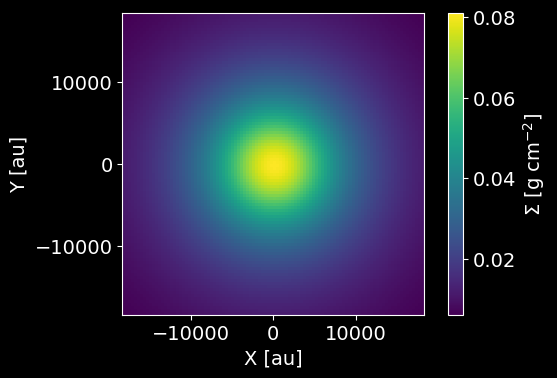

In [16]:
with quantity_support():
    pl.imshow(column, extent=[-rmax.value, rmax.value, -rmax.value, rmax.value])
    cb = pl.colorbar()
    cb.set_label("$\\Sigma$ [g cm$^{-2}$]")
    pl.xlabel("X [au]")
    pl.ylabel("Y [au]")

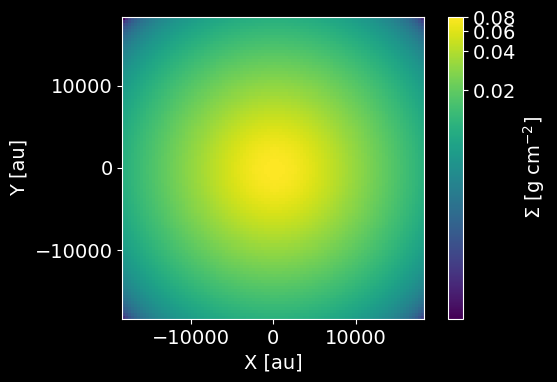

In [17]:
# same plot log-scaled
with quantity_support():
    pl.imshow(column, extent=[-rmax.value,rmax.value,-rmax.value,rmax.value],
              norm=simple_norm(column, stretch='log'))
    cb = pl.colorbar()
    cb.set_label("$\\Sigma$ [g cm$^{-2}$]")
    pl.xlabel("X [au]")
    pl.ylabel("Y [au]")

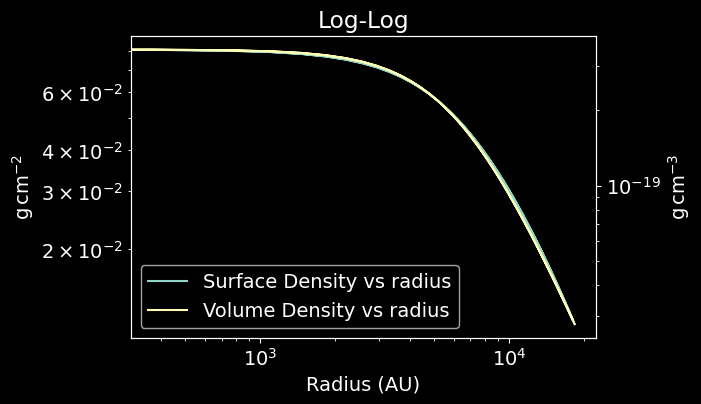

In [18]:
with quantity_support():
    colors = pl.rcParams["axes.prop_cycle"].by_key()["color"]
    ax1 = pl.gca()
    ax1.loglog(rr_2d[50,50,:], column[50,:], label='Surface Density vs radius', color=colors[0])
    ax2 = ax1.twinx()
    ax2.loglog(rr_3d[50,50,:], density[50,50,:], label='Volume Density vs radius', color=colors[1])
    ax1.set_xlabel("Radius (AU)")

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.set_title("Log-Log")
    _=ax2.legend(lines + lines2, labels + labels2, loc='best')

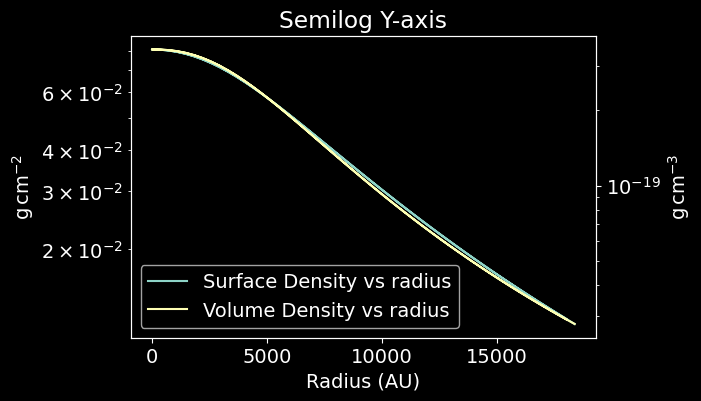

In [19]:
with quantity_support():

    colors = pl.rcParams["axes.prop_cycle"].by_key()["color"]
    ax1 = pl.gca()
    ax1.semilogy(rr_2d[50,50,:], column[50,:],
                 label='Surface Density vs radius', color=colors[0])
    ax1.set_xlabel("Radius (AU)")
    
    ax2 = ax1.twinx()
    ax2.semilogy(rr_3d[50,50,:], density[50,50,:],
                 label='Volume Density vs radius', color=colors[1])

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.set_title("Semilog Y-axis")
    _=ax2.legend(lines + lines2, labels + labels2, loc='best')
    

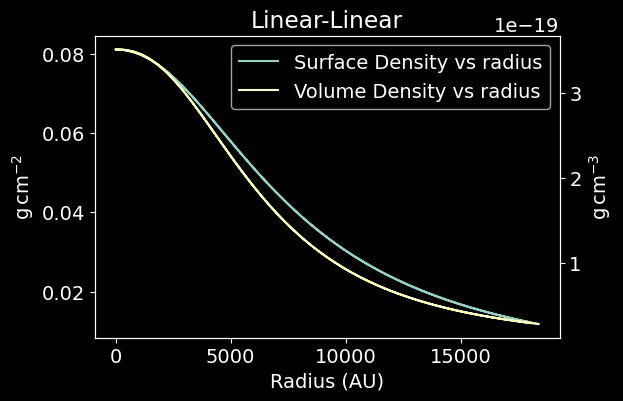

In [20]:
with quantity_support():

    colors = pl.rcParams["axes.prop_cycle"].by_key()["color"]
    ax1 = pl.gca()
    ax1.plot(rr_2d[50,50,:], column[50,:],
                 label='Surface Density vs radius', color=colors[0])
    ax1.set_xlabel("Radius (AU)")
    
    ax2 = ax1.twinx()
    ax2.plot(rr_3d[50,50,:], density[50,50,:],
                 label='Volume Density vs radius', color=colors[1])

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.set_title("Linear-Linear")
    _=ax2.legend(lines + lines2, labels + labels2, loc='best')
    

Convert to number densities by dividing by particle mass:

(peak N(H$_2$) should be $\sim2.7\times10^{22} \mathrm{cm}^{-2}$ according to [Nielbock+ 2012](https://www.aanda.org/articles/aa/pdf/2012/11/aa19139-12.pdf) [ADS](https://ui.adsabs.harvard.edu/abs/2012A%26A...547A..11N/abstract), who do extensive modeling of B68)

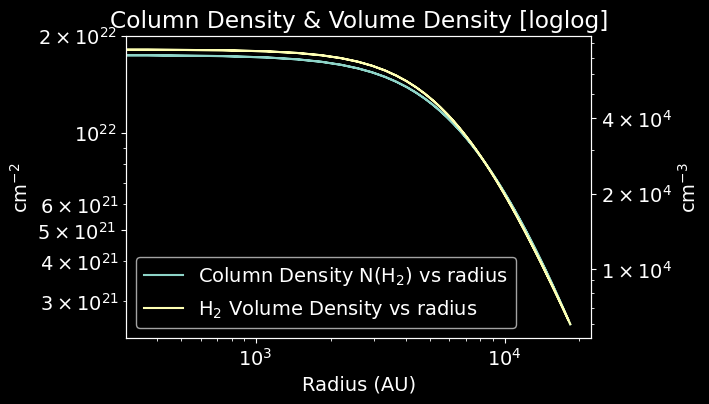

In [21]:
with quantity_support():

    colors = pl.rcParams["axes.prop_cycle"].by_key()["color"]
    ax1 = pl.gca()
    ax1.set_xlabel("Radius (AU)")

    ax1.loglog(rr_2d[50,50,:], (column[50,:]/(2.8*u.Da)).to(u.cm**-2),
               label='Column Density N(H$_2$) vs radius', color=colors[0])
    ax1.set_yticks([5e21, 1e22, 2e22])
    ax1.set_yticklabels([r'$5\times10^{21}$','$10^{22}$', r'$2\times10^{22}$'])
    
    ax2 = ax1.twinx()
    ax2.loglog(rr_3d[50,50,:], (density[50,50,:]/(2.8*u.Da)).to(u.cm**-3),
               label='H$_2$ Volume Density vs radius', color=colors[1])
    ax2.set_yticks([1e4, 2e4, 4e4])
    ax2.set_yticklabels([r'$1\times10^{4}$',r'$2\times10^{4}$', r'$4\times10^{4}$'])


    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.set_title("Column Density & Volume Density [loglog]")
    _=ax2.legend(lines + lines2, labels + labels2, loc='best')

# Dust Emissivity

In order to compute what we should see, we need to figure out how much light each element of mass produces.

A blackbody has the form:

$$B_\nu = \frac{2 h \nu^3}{c^2} \left(1-e^{h \nu / k_B T}\right)^{-1}$$

with units $[B_\nu] = \mathrm{Jy}$

The spectral flux density from a blackbody $F_{\nu} = \pi B_{\nu}$ from integrating over a hemisphere (see eqn 2.107-2.110 from https://www.cv.nrao.edu/~sransom/web/Ch2.html).  

The flux emitted into a steradian is then $S_\nu = F_\nu / (2 \pi) = B_\nu/2$, since the whole sphere is 4$\pi$ steradians.

Dust has a long-wavelength opacity that is well-approximated by a power law:

$$\kappa_{dust} = \kappa_0 \left(\frac{\nu}{\nu_0}\right)^\beta$$

We determine $\kappa_0$ and $\beta$ empirically (in the laboratory and/or from observations).  $\nu_0$ is the frequency at which we measure $\kappa_0$

The modified blackbody for dust is given by:

\begin{eqnarray}
   S_\nu &=& \frac{B_\nu}{2} \left(1-e^{-\tau_{dust}}\right)\\
         &=&  \frac{1}{2} \frac{2 h \nu^3}{c^2} \left(1-e^{h \nu / k_B T}\right)^{-1} \left(1-e^{-\tau_{dust}}\right)\\
         &=&  \frac{1}{2} \frac{2 h \nu^3}{c^2} \left(1-e^{h \nu / k_B T}\right)^{-1} \left(1-e^{-\kappa_\nu \Sigma}\right)
\end{eqnarray}

in units of [Jy sr$^{-1}$], where $\kappa_\nu = \kappa_{0} \left(\frac{\nu}{\nu_0}\right)^{\beta}$ is the dust opacity index with units $[\kappa_\nu] = \frac{\mathrm{cm}^2}{\mathrm{g}}$.  


$\Sigma$ is the surface density in $[\Sigma] = \frac{\mathrm{g}}{\mathrm{cm^2}}$.  


The optical depth $\tau = \kappa_\nu \Sigma$

optical depth = (dust opacity constant) times (surface density)

We can adopt $\kappa_{1 mm} = 0.0136$ cm$^{2}$ g$^{-1}$ from [Ossenkopf & Henning 1994](https://ui.adsabs.harvard.edu/abs/1994A%26A...291..943O/abstract).

Note that this is the _opacity per total mass_ - we call it the dust opacity, but the mass is the mass of _all gas and dust_.

The gas-to-dust ratio is about 100 (see papers and textbooks by Bruce Draine).

So if you have 1 g/cm$^2$ of gas mixed with dust, the opacity is $\tau=\kappa \Sigma = 0.01$.

If you instead had 1 g/cm$^2$ of pure dust - no gas! - the opacity would be $\tau = 1$.

We can now calculate the optical depth of our core (at a hypothetical observed wavelength of 1mm):

In [47]:
opacity = 0.0136*u.cm**2*u.g**-1
optical_depth = (column * opacity).decompose()
optical_depth

<Quantity [[8.34625052e-05, 8.51404007e-05, 8.68468684e-05, ...,
            8.85814685e-05, 8.68468684e-05, 8.51404007e-05],
           [8.51404007e-05, 8.68827284e-05, 8.86559313e-05, ...,
            9.04596128e-05, 8.86559313e-05, 8.68827284e-05],
           [8.68468684e-05, 8.86559313e-05, 9.04983255e-05, ...,
            9.23737057e-05, 9.04983255e-05, 8.86559313e-05],
           ...,
           [8.85814685e-05, 9.04596128e-05, 9.23737057e-05, ...,
            9.43234620e-05, 9.23737057e-05, 9.04596128e-05],
           [8.68468684e-05, 8.86559313e-05, 9.04983255e-05, ...,
            9.23737057e-05, 9.04983255e-05, 8.86559313e-05],
           [8.51404007e-05, 8.68827284e-05, 8.86559313e-05, ...,
            9.04596128e-05, 8.86559313e-05, 8.68827284e-05]]>

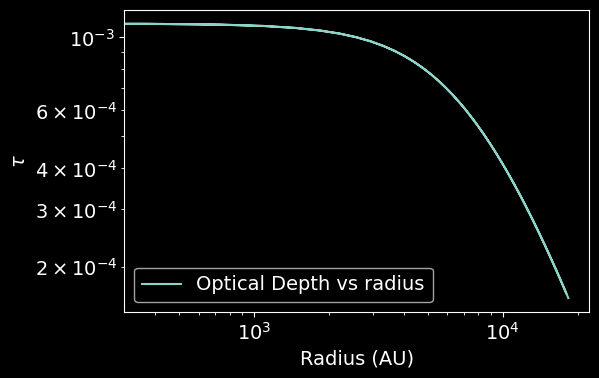

In [23]:
with quantity_support():
    colors = pl.rcParams["axes.prop_cycle"].by_key()["color"]
    ax1 = pl.gca()
    ax1.loglog(rr_2d[50,50,:], optical_depth[50,:], label='Optical Depth vs radius', color=colors[0])
    ax1.set_xlabel("Radius (AU)")
    ax1.legend(loc='best')
    ax1.set_ylabel("$\\tau$")


We model $\tau << 1$, which means this is a very optically thin object.

\* This is true at long wavelengths; it's only marginally optically thick at near-infrared wavelengths.

# Optical depth -> intensity

The modified blackbody approximates, in the $\tau<<1$ regime, to:

\begin{eqnarray}
S_\nu & = & \frac{1}{2} \frac{2 h \nu^3}{c^2} \left(e^{h \nu / k_B T}-1\right)^{-1} \left (1-e^{-\tau}\right)\\
S_\nu & = & \frac{1}{2} \frac{2 h \nu^3}{c^2} \left(e^{h \nu / k_B T}-1\right)^{-1} \tau \\
      & = & \frac{1}{2} \frac{2 h \nu^3}{c^2} \left(e^{h \nu / k_B T}-1\right)^{-1} \kappa_\nu \Sigma
\end{eqnarray}

(recall the Taylor series: $e^{-x} \approx 1-x+\mathcal{O}(x^2)$)


We can calculate the flux density at 1mm now (remember we assume T=15 K):

$$f_\nu =  \frac{h \nu^3}{c^2} \left(e^{h \nu / k_B T}-1\right)^{-1} \tau_\nu$$

In [24]:
nu = (1*u.mm).to(u.GHz, u.spectral())
fnu = (constants.h * nu**3 / constants.c**2 *
       (np.exp(constants.h * nu / (constants.k_B * T))-1)**-1 * 
       optical_depth).to(u.Jy) / u.sr
fnu

<Quantity [[1030051.39309002, 1050759.11751796, 1071819.4659561 , ...,
            1093227.01030782, 1071819.4659561 , 1050759.11751796],
           [1050759.11751796, 1072262.03220695, 1094145.99152696, ...,
            1116406.10291726, 1094145.99152696, 1072262.03220695],
           [1071819.4659561 , 1094145.99152696, 1116883.87443136, ...,
            1140028.85477304, 1116883.87443136, 1094145.99152696],
           ...,
           [1093227.01030782, 1116406.10291726, 1140028.85477304, ...,
            1164091.74583088, 1140028.85477304, 1116406.10291726],
           [1071819.4659561 , 1094145.99152696, 1116883.87443136, ...,
            1140028.85477304, 1116883.87443136, 1094145.99152696],
           [1050759.11751796, 1072262.03220695, 1094145.99152696, ...,
            1116406.10291726, 1094145.99152696, 1072262.03220695]] Jy / sr>

# Definition:  Brightness temperature

The _brightness temperature_ is commonly used to express the surface brightness of an object.  It is given by

$$F_\nu \equiv \frac{2 k_B T_B \nu^2}{c^2} $$

i.e., it is defined by the Rayleigh-Jeans approximation.

Therefore
$$ T_B = \frac{c^2 F_\nu}{2 k_B \nu^2}$$

In [44]:
tb = (fnu * u.sr * constants.c**2 / (2*constants.k_B * nu**2)).to(u.K)
tb.max()

<Quantity 0.0049274 K>

In [43]:
# astropy version (same as above)
tb2 = fnu.to(u.K, u.brightness_temperature(nu))
tb2.max()

<Quantity 0.0049274 K>

# In-class Exercise

Derive, from the Planck function:
$$B_\nu = \frac{2 h \nu^3}{c^2} \left(1-e^{h \nu / k_B T}\right)^{-1}$$

the Rayleigh-Jeans law.

Try it on your own first, then after ~2 minutes, I'll ask you to check with your neighbor.

Aside:

Recall the Rayleigh-Jeans approximation from the Blackbody function.

$$B_\nu = \frac{2 h \nu^3}{c^2} \left(1-e^{h \nu / k_B T}\right)^{-1}$$

For $\nu << \nu(B_{max})$, we have, again from Taylor expansion

$$\left(1-e^{h \nu / k_B T}\right) \approx \frac{h \nu}{k_B T}$$

which results in 

$$B_\nu(RJ) = \frac{2 h \nu^3}{c^2}\frac{k_B T}{h \nu} $$

reducing to

$$B_\nu(RJ) = \frac{2 k_B T \nu^2}{c^2} $$

Now we convert our optical depth radial profile to a predicted intensity radial profile:

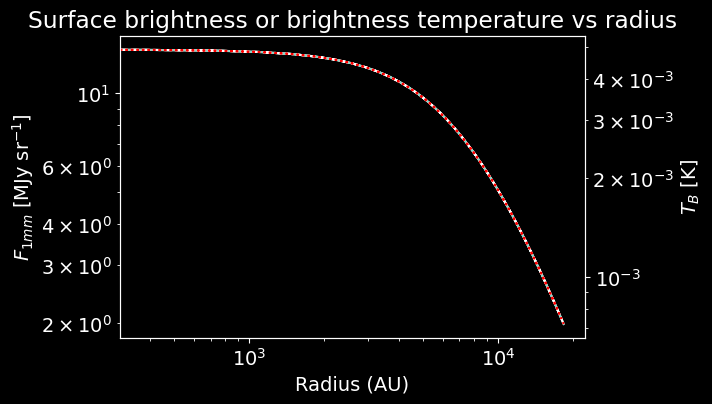

In [27]:
with quantity_support():
    colors = pl.rcParams["axes.prop_cycle"].by_key()["color"]
    ax1 = pl.subplot()
    ax1.loglog(rr_2d[50,50,:], fnu[50,:].to(u.MJy/u.sr), label='Surface Brightness vs radius', color=colors[0])
    ax2 = ax1.twinx()
    ax2.loglog(rr_2d[50,50,:], tb[50,:], label='Brightness Temperature vs radius', color='w', linestyle='--')
    ax2.loglog(rr_2d[50,50,:], tb2[50,:], label='Brightness Temperature vs radius', color='r', linestyle=':')
    ax1.set_xlabel("Radius (AU)")
    #ax1.legend(loc='best')
    ax1.set_title("Surface brightness or brightness temperature vs radius")
    ax1.set_ylabel("$F_{1 mm}$ [MJy sr$^{-1}$]")
    ax2.set_ylabel("$T_B$ [K]")

This is our predicted measurement: a telescope can observe this.

# Predicting precisely what a telescope sees

We need to consider the telescope's spatial resolution.

What would we observe if we measured the whole object with a telescope whose resolution is ~$r_0$?

This is a 'beam matched' observation: we barely resolve the object.

We simply average the brightness over the area and multiply by the area to obtain the total flux.

Let's say we're observing B68, which has $r_{FWHM}\sim150"$.  We multiply the surface brightness in Jy/sr by the surface area in sr:

In [28]:
FWHM_to_sigma = np.sqrt(8*np.log(2))
total_fluxdensity = (fnu[rr_2d[0,:,:] < rmax].mean() * (150*u.arcsec / FWHM_to_sigma)**2 * np.pi).to(u.Jy)
total_fluxdensity

<Quantity 1.36713996 Jy>

From [Bianchi+ 2003](https://www.aanda.org/articles/aa/pdf/2003/09/aael211.pdf):
"The final SIMBA image of Barnard 68 has a residual noise of 5.5 mJy beam$^{−1}$ (1-σ), equivalent to 0.36 MJy sr$^{−1}$ for the SIMBA resolution. The integrated flux is $F_{1.2 mm} = 0.7 \pm 0.2$ Jy."

Our model matches the data to within a factor of 2 - this is very good agreement.

We can compare their surface brightness sensitivity to our predicted flux to see that they should have (and did) detect the core out to its $r_{max}$

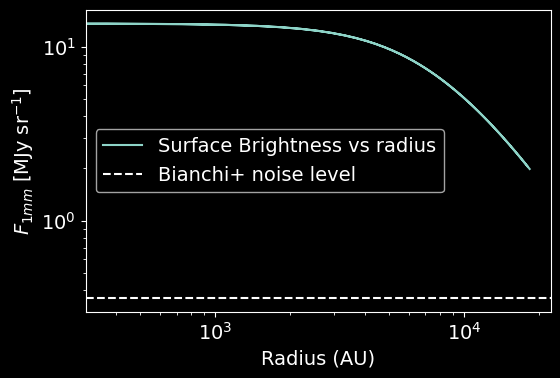

In [29]:
with quantity_support():
    colors = pl.rcParams["axes.prop_cycle"].by_key()["color"]
    ax1 = pl.subplot()
    ax1.loglog(rr_2d[50,50,:], fnu[50,:].to(u.MJy/u.sr), label='Surface Brightness vs radius', color=colors[0])
    ax1.axhline(0.36*u.MJy/u.sr, linestyle='--', label='Bianchi+ noise level')
    ax1.set_xlabel("Radius (AU)")
    ax1.legend(loc='center left')
    ax1.set_ylabel("$F_{1 mm}$ [MJy sr$^{-1}$]")
    ax2.set_ylabel("$T_B$ [K]")

## Summary

We showed how to predict the surface brightness of an optically thin Bonnor-Ebert dust core in two different units from "first principles", i.e., using a model of the gas density structure, the blackbody function, and the opacity function of dust.

Together, these represent nearly the full suite of tools you need to prepare an observing proposal.

## Observing extended sources

The surface brightness we measure is the same we would observe if B68 were 10x further (D=1.2 kpc) and therefore smaller (15"): For resolved sources, the surface brightness does not change with distance.

However, the total flux would decrease by 100x (by $D^2$) because the area at that constant brightness decreases by 100x.

# What about filaments?

We can do basically the same thing

(but I'll skip this in lecture)

In [30]:
# Eqn 60 of Ostriker
c_s = 0.2*u.km/u.s
M_crit_cyl = (2 * c_s**2 / constants.G).to(u.M_sun/u.pc)
M_crit_cyl

<Quantity 18.60068329 solMass / pc>

Equation 62 of [Ostriker](https://ui.adsabs.harvard.edu/abs/1964ApJ...140.1056O/abstract) is:

$$ r_{1/2} = \left(\frac{M_{crit}}{\pi \rho_c}\right)^{1/2}$$

or
$$ \rho_c = \frac{M_{crit}}{\pi r_{1/2}^2} = \frac{M_{crit}}{8 \pi r_{0}^2} $$

In [31]:
# we make an arbitrary choice for r_half
# (choice is selected to make plots below nice)
r_half = 0.02*u.pc
r0_cyl = r_half/8**0.5
rho_c_cyl = M_crit_cyl / (np.pi * 8 * r0_cyl**2)
r0_cyl, r_half, rho_c_cyl, (rho_c_cyl/mu).to(u.cm**-3)

(<Quantity 0.00707107 pc>,
 <Quantity 0.02 pc>,
 <Quantity 14801.95345311 solMass / pc3>,
 <Quantity 262298.84327992 1 / cm3>)

In [32]:
# we'll use r_max = twice r_half
rmaxcyl = 2 * r_half

# now we _only_ use 2D coordinates
rr_2dcyl = ((yy-sz/2.)**2 + (xx-sz/2.)**2)**0.5
rr_2dcyl = rr_2dcyl / (sz/2.) * rmaxcyl

print(f"r_max = {rmaxcyl}")

r_max = 0.04 pc


Equation 57 of Ostriker is:

$$ \rho(r) = \rho_c \left(\frac{1}{1+\frac{1}{8} \left(\frac{r}{r_0}\right)^2}\right)^2 $$

In [33]:
# calculate cylinder density
def cyl_density_func(rr, r0=r0_cyl, rho_c_cyl=rho_c_cyl):
    xi = rr / r0
    return rho_c_cyl * (1 / (1 + (1/8.)*(xi)**2))**2
cyl_density = cyl_density_func(rr_2dcyl)

As a sanity check, we test that the integral of our model 18.570029670095394 solMass / pc is approximately the critical cylinder mass {M_crit_cyl}.


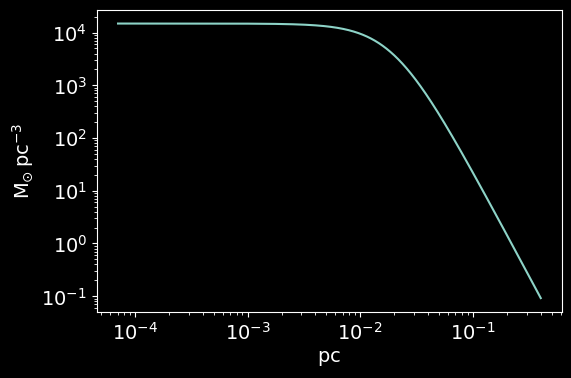

In [34]:
with quantity_support():
    rr = np.geomspace(0.01*r0_cyl, 20*r_half, 5000)
    pl.loglog(rr, cyl_density_func(rr))
integral = (cyl_density_func(rr)[:-1]*np.diff(rr) * 2 * np.pi * rr[:-1]).sum()
print(f"As a sanity check, we test that the integral of our model {integral} is"
      " approximately the critical cylinder mass {M_crit_cyl}.")

In [35]:
# our integral will now be along the x direction instead of z
dx = 2 * rmaxcyl / sz
cyl_column = (cyl_density * dx).sum(axis=2).to(u.g/u.cm**2)

In [36]:
# sanity check: the dx's calculated two ways should be equal
from astropy.tests.helper import assert_quantity_allclose
assert_quantity_allclose(np.diff(rr_2dcyl[50,50,:]).to(u.au)[-1], dx.to(u.au))
np.diff(rr_2dcyl[50,50,:]).to(u.au)[-1], dx.to(u.au)

(<Quantity 165.011845 AU>, <Quantity 165.011845 AU>)

In [37]:
# check that the integral gives our target line density
# must be >1/2 M_crit, since we have defined our radius such that that is true
line_mass_density = (cyl_density[0,:,:]*dx**2).sum().to(u.M_sun/u.pc)
print(f"Line mass density calculated = {line_mass_density}")
assert line_mass_density > 0.5 * M_crit_cyl

Line mass density calculated = 15.457219868451434 solMass / pc


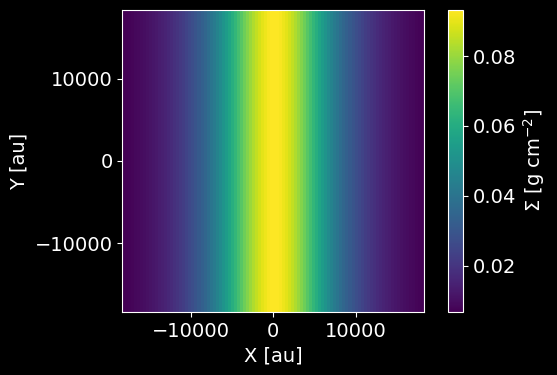

In [38]:
with quantity_support():
    pl.imshow(cyl_column, extent=[-rmax.value,rmax.value,-rmax.value,rmax.value])
    cb = pl.colorbar()
    cb.set_label("$\\Sigma$ [g cm$^{-2}$]")
    pl.xlabel("X [au]")
    pl.ylabel("Y [au]")

We can compare the radial profiles of the sphere and cylinder

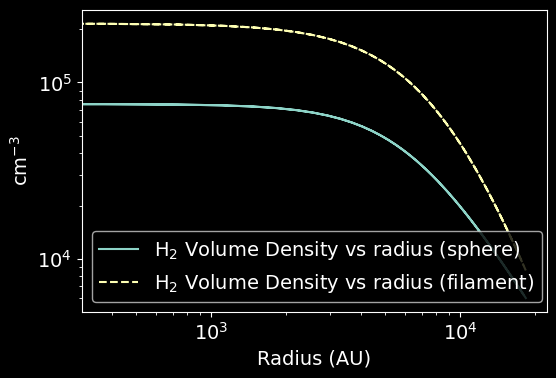

In [39]:
with quantity_support():

    colors = pl.rcParams["axes.prop_cycle"].by_key()["color"]
    ax1 = pl.gca()
    ax1.set_xlabel("Radius (AU)")

    ax1.loglog(rr_3d[50,50,:], (density[50,50,:]/(2.8*u.Da)).to(u.cm**-3),
               label='H$_2$ Volume Density vs radius (sphere)')
    ax1.loglog(rr_2d[50,:,50], (cyl_density[50,:,50]/(2.8*u.Da)).to(u.cm**-3),
               label='H$_2$ Volume Density vs radius (filament)', linestyle='--')

    ax1.legend(loc='lower left')

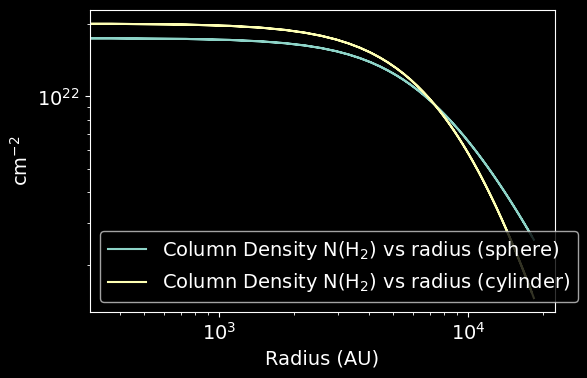

In [40]:
with quantity_support():

    colors = pl.rcParams["axes.prop_cycle"].by_key()["color"]
    ax1 = pl.gca()
    ax1.set_xlabel("Radius (AU)")

    ax1.loglog(rr_2d[50,50,:], (column[50,:]/(2.8*u.Da)).to(u.cm**-2),
               label='Column Density N(H$_2$) vs radius (sphere)',)
    ax1.loglog(rr_2d[50,50,:], (cyl_column[50,:]/(2.8*u.Da)).to(u.cm**-2),
               label='Column Density N(H$_2$) vs radius (cylinder)',)    
    #ax1.set_yticks([5e21, 1e22, 2e22])
    #ax1.set_yticklabels([r'$5\times10^{21}$','$10^{22}$', r'$2\times10^{22}$'])

    ax1.legend(loc='best')

Nielbock 2012:
<img src="graphics/nielbock2012_b68.png">

Compare to the next step, a protostellar core:
<img src="graphics/schmalzl2014_cb17.png">

Optional next step, if we want to go deeper on this topic:

* Going from observations to inferred properties by grid modeling
* or by Abel inversion (e.g., [Roy 2014](https://ui.adsabs.harvard.edu/abs/2014A%26A...562A.138R/abstract))
* Modeling cores on a background of filaments ([Steinacker+ 2016](https://ui.adsabs.harvard.edu/abs/2016A%26A...593A...6S/abstract))